In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [8]:
cd ..

/atlas/u/kechoi/multi-fairgen


In [9]:
from classification.models.mlp import MLPClassifier, MLPClassifierv2
from classification.models.flow_mlp import FlowClassifier
import argparse
import yaml

In [10]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    if isinstance(config, list):
        # from creating config files
        for i in range(len(config)):
            for key, value in config[i].items():
                if isinstance(value, dict):
                    new_value = dict2namespace(value)
                else:
                    new_value = value
                setattr(namespace, key, new_value)
    else:
        # vanilla training
        for key, value in config.items():
            if isinstance(value, dict):
                new_value = dict2namespace(value)
            else:
                new_value = value
            setattr(namespace, key, new_value)
    return namespace

# Load data

In [11]:
import torch
from torch.distributions import Normal

In [12]:
p = Normal(0, 1)
q = Normal(3, 1)

In [13]:
px = p.sample((2000,2))
qx = q.sample((2000,2))

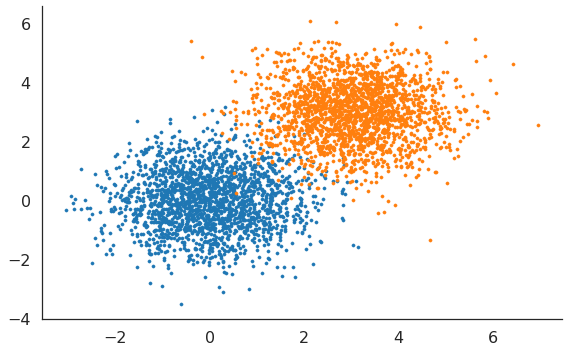

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [15]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([4000, 2])

In [16]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [17]:
true_log_r = torch.log(true_ratios)

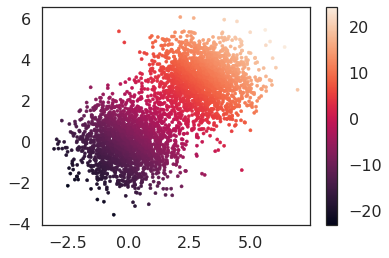

In [18]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_r.data.cpu().numpy())
plt.colorbar()

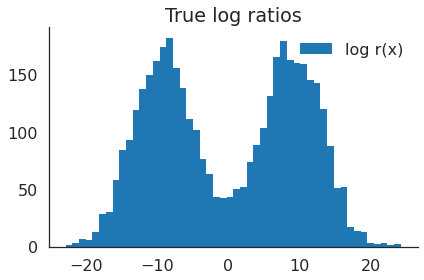

In [19]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

------

# Check encodings

### Check real data

In [28]:
cd multi-fairgen/src

/atlas/u/kechoi/multi-fairgen/src


In [15]:
# load data
data_dir = '../data/'
split = 'test'
dim = 2
rho = 0.95
fpath = os.path.join(data_dir, 'gaussians_mi', '{}_d{}_rho{}.npz'.format(split, dim, rho))

In [16]:
record = np.load(fpath)
p = record['p'][0:5000]
q = record['q'][0:5000]
true_xs = np.vstack([p, q])
true_xs.shape

(10000, 2)

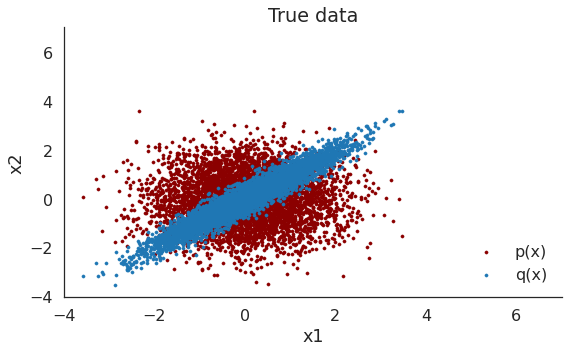

In [17]:
plt.figure(figsize=(8,5))
plt.scatter(p[:,0], p[:,1], s=10, label='p(x)', color='darkred')
plt.scatter(q[:,0], q[:,1], s=10, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('True data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()

# Load flow

In [10]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [11]:
device = 'cuda'

In [13]:
# load flow
import torch
import os
from flows.models.maf import MAF

model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)
restore_file = 'flows/results/mi_flow_perc1.0/'
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])
model = model.to(device)
model.eval()

MAF(
  (net): FlowSequential(
    (0): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (1): BatchNorm()
    (2): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      )
    )
    (3): BatchNorm()
    (4): MADE(
      (net_input): MaskedLinear(in_features=2, out_features=100, bias=True)
      (net): Sequential(
        (0): ReLU()
        (1): MaskedLinear(in_features=100, out_features=100, bias=True)
        (2): ReLU()
        (3): MaskedLinear(in_features=100, out_features=4, bias=True)
      

In [21]:
z, _ = model.forward(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

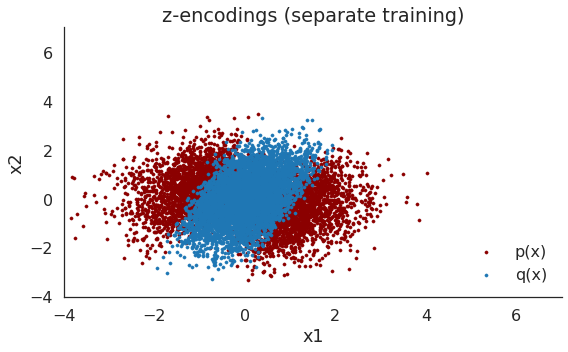

In [22]:
plt.figure(figsize=(8,5))
plt.scatter(z[:,0][:5000], z[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(z[:,0][5000:], z[:,1][5000:], s=10, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('z-encodings (separate training)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()

In [23]:
xhat, _ = model.inverse(torch.from_numpy(z).float().cuda())

In [24]:
xhat.size()

torch.Size([10000, 2])

In [25]:
x_hat = xhat.data.cpu().numpy()

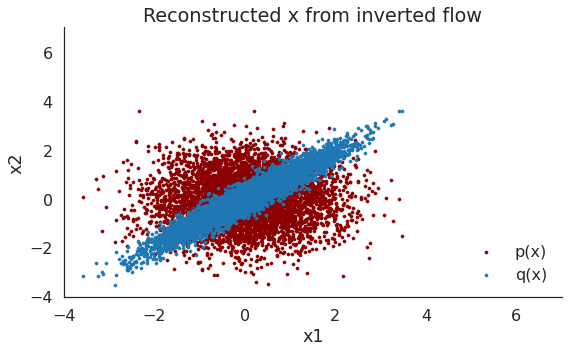

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(x_hat[:,0][:5000], x_hat[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(x_hat[:,0][5000:], x_hat[:,1][5000:], s=10, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Reconstructed x from inverted flow')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='lower right')
sns.despine()
plt.tight_layout()

--------

# Discriminative FlowClassifier

In [28]:
device = 'cuda'

In [29]:
with open(os.path.join('configs/classification/mi/disc_flow_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [30]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/mi_disc_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [31]:
# get dres
flow_mlp.eval()
z = flow_mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

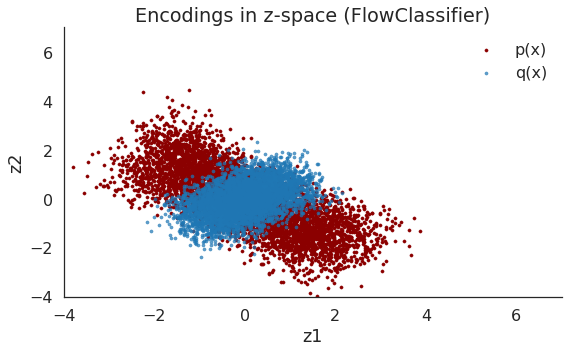

In [32]:
plt.figure(figsize=(8,5))
plt.scatter(z[:,0][:5000], z[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(z[:,0][5000:], z[:,1][5000:], s=10, alpha=0.7, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Encodings in z-space (FlowClassifier)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
sns.despine()
plt.tight_layout()

# Jointly trained

In [27]:
with open(os.path.join('configs/classification/mi/joint_flow_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [28]:
flow_mlp = FlowClassifier(new_config)
restore_file = 'classification/results/mi_flow_mlp_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
flow_mlp.load_state_dict(state['state_dict'])
flow_mlp = flow_mlp.to(device)

In [29]:
# get dres
flow_mlp.eval()
z = flow_mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

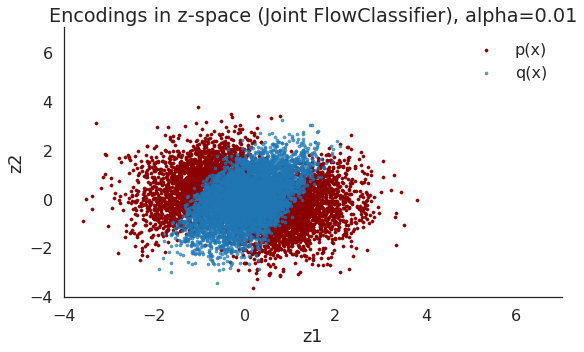

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(z[:,0][:5000], z[:,1][:5000], s=10, label='p(x)', color='darkred')
plt.scatter(z[:,0][5000:], z[:,1][5000:], s=10, alpha=0.7, label='q(x)')
plt.ylim(-4, 7)
plt.xlim(-4, 7)

plt.title('Encodings in z-space (Joint FlowClassifier), alpha=0.01')
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend()
sns.despine()
plt.tight_layout()

# X-Space Baseline

actually can't look at encodings here but you can check DREs

In [31]:
with open(os.path.join('configs/classification/mi/mi_perc1.0.yaml'), 'r') as f:
    config = yaml.safe_load(f)
new_config = dict2namespace(config)

In [32]:
mlp = MLPClassifierv2(new_config)
restore_file = 'classification/results/mi_perc1.0/checkpoints/model_best.pth'
state = torch.load(restore_file, map_location='cuda')
mlp.load_state_dict(state['state_dict'])
mlp = mlp.to(device)

In [ ]:
# get dres
mlp.eval()
z = mlp.flow_encode(torch.from_numpy(true_xs).float().cuda())
z = z.data.cpu().numpy()

------------

# Can we look at the DREs?

Flow MLP

In [45]:
logits, probas = flow_mlp(torch.from_numpy(q).cuda())  # only samples from the joint!

In [46]:
from classification.utils import logsumexp_1p

In [47]:
log_r = logsumexp_1p(-logits) - logsumexp_1p(logits)

In [48]:
log_r.mean()

tensor(1.1339, device='cuda:0', grad_fn=<MeanBackward0>)

In [49]:
pwd

'/atlas/u/kechoi/multi-fairgen/src'

In [21]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [36]:
disc = np.load('classification/results/mi_disc_flow_mlp_perc1.0/est_mi.npy')
baseline = np.load('classification/results/mi_perc1.0/est_mi.npy')
joint1 = np.load('classification/results/mi_flow_mlp_perc1.0_alpha0.1/est_mi.npy')
joint = np.load('classification/results/mi_flow_mlp_perc1.0_alpha0.5/est_mi.npy')
flow = np.load('classification/results/mi_z_perc1.0/est_mi.npy')

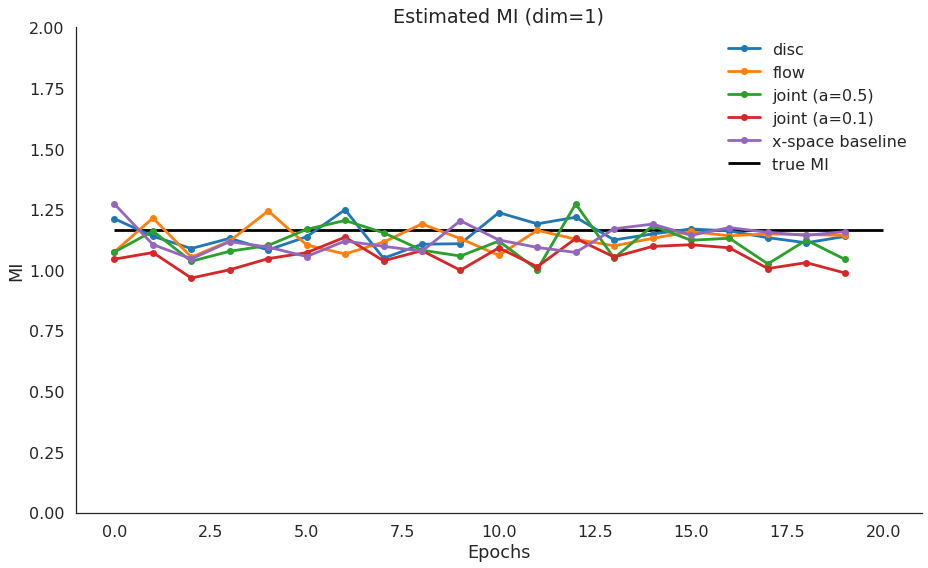

In [37]:
plt.figure(figsize=(13,8))

plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=7)
plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
plt.plot(range(len(disc)), joint[0:20], '-o', label='joint (a=0.5)', markersize=7)
plt.plot(range(len(disc)), joint1[0:20], '-o', label='joint (a=0.1)', markersize=7)
plt.plot(range(len(disc)), baseline, '-o', label='x-space baseline', markersize=7)

plt.hlines(1.16395145, 0, 20, color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
plt.ylim(0, 2)
plt.title('Estimated MI (dim=1)')
plt.legend()
sns.despine()
plt.tight_layout()

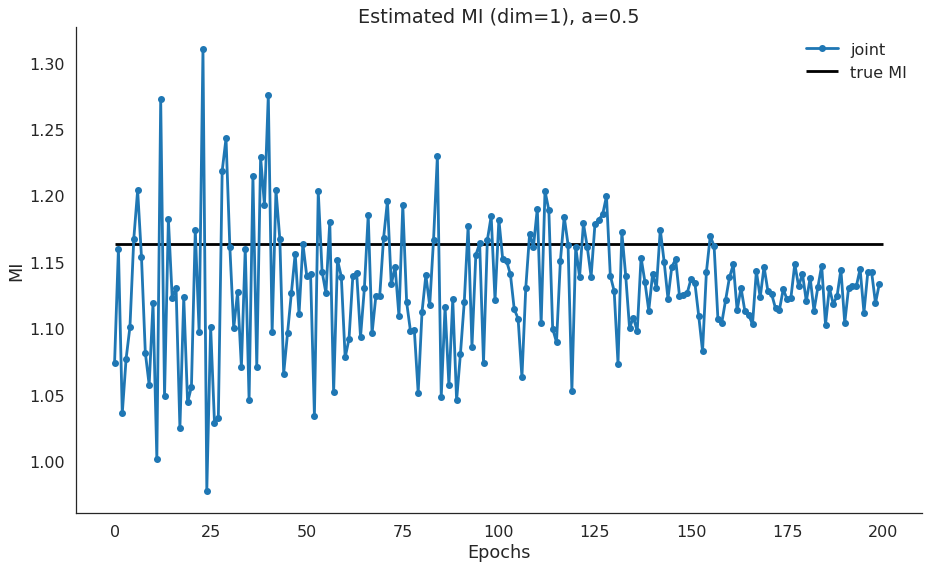

In [39]:
plt.figure(figsize=(13,8))

plt.plot(range(len(joint)), joint, '-o', label='joint', markersize=7)

plt.hlines(1.16395145, 0, len(joint), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
plt.title('Estimated MI (dim=1), a=0.5')
plt.legend()
sns.despine()
plt.tight_layout()

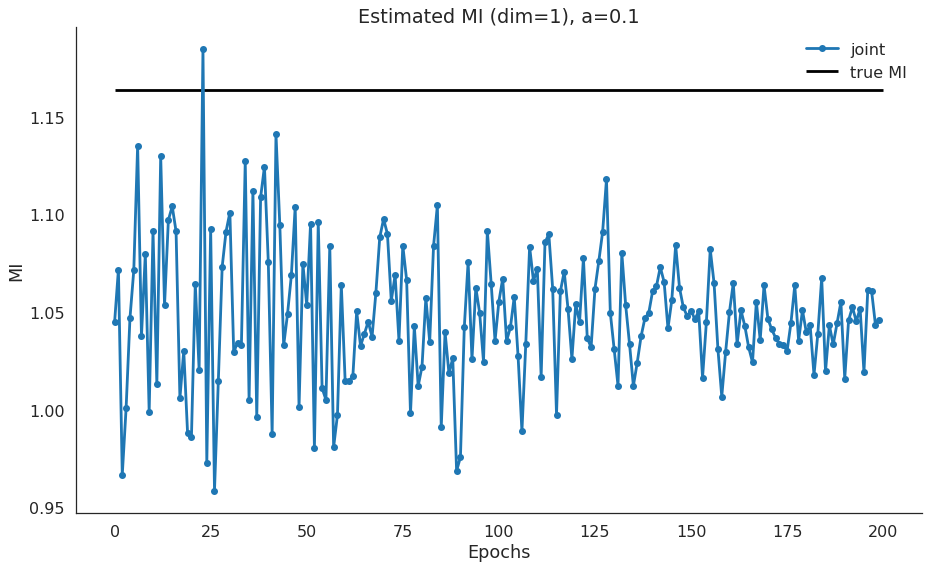

In [40]:
plt.figure(figsize=(13,8))

plt.plot(range(len(joint)), joint1, '-o', label='joint', markersize=7)

plt.hlines(1.16395145, 0, len(joint1), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
plt.title('Estimated MI (dim=1), a=0.1')
plt.legend()
sns.despine()
plt.tight_layout()

In [42]:
def rho_to_mi(dim, rho):
    """Obtain the ground truth mutual information from rho."""
    return -0.5 * np.log(1 - rho**2) * dim


def mi_to_rho(dim, mi):
    """Obtain the rho for Gaussian give ground truth mutual information."""
    return np.sqrt(1 - np.exp(-2.0 / dim * mi))

In [51]:
n_iter = 20000
mis = np.round(np.linspace(0.5, 5.5 - 1e-9, n_iter)) * 2.0

In [52]:
np.unique(mis)

array([ 0.,  2.,  4.,  6.,  8., 10.])

In [45]:
for m in mis:
    print(mi_to_rho(20,m))

0.0
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.4257

0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.42575726

0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.425757262911648
0.42575726

0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327

0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327621625
0.5741776327

0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634

0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634

0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634025771
0.6717055634

0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231

0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231004291
0.7420721231

0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976

0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976206501
0.7950600976

In [46]:
mis = np.ravel([mi_to_rho(20,m) for m in mis])

In [47]:
np.unique(mis)

array([0.        , 0.42575726, 0.57417763, 0.67170556, 0.74207212,
       0.7950601 ])

In [58]:
for rho in [0.9, 0.95]:
    print(rho_to_mi(20, rho))

16.607312068216512
23.279029009783354


In [59]:
mis = np.round(np.linspace(16.61, 23.28 - 1e-9, n_iter))

In [61]:
len(mis)

20000

In [60]:
np.unique(mis)

array([17., 18., 19., 20., 21., 22., 23.])

In [63]:
rho_to_mi(20,0.95)

23.279029009783354

Let's look at some of these results

In [21]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [41]:
disc = np.load('classification/results/mi_disc_d40_perc1.0/est_mi.npy')
joint = np.load('classification/results/mi_joint_d40_alpha0.1/est_mi.npy')
joint1 = np.load('classification/results/mi_joint_d40_alpha0.5/est_mi.npy')
joint2 = np.load('classification/results/mi_joint_d40_alpha0.9/est_mi.npy')
joint3 = np.load('classification/results/mi_joint_d40_alpha0.9_rho0.9/est_mi.npy')

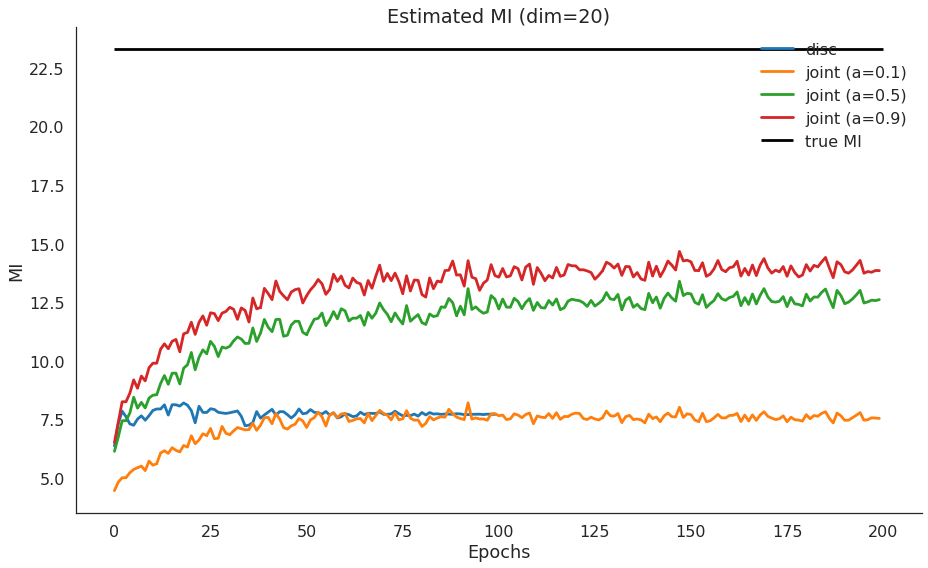

In [44]:
plt.figure(figsize=(13,8))

# plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=7)
# # plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
# plt.plot(range(len(disc)), joint[0:100], '-o', label='joint (a=0.1)', markersize=7)
# plt.plot(range(len(disc)), joint1[0:100], '-o', label='joint (a=0.5)', markersize=7)
# plt.plot(range(len(disc)), joint2[0:100], '-o', label='joint (a=0.9)', markersize=7)
# # plt.plot(range(len(disc)), baseline, '-o', label='x-space baseline', markersize=7)

plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=1)
# plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
plt.plot(range(len(joint)), joint, '-o', label='joint (a=0.1)', markersize=1)
plt.plot(range(len(joint)), joint1, '-o', label='joint (a=0.5)', markersize=1)
plt.plot(range(len(joint)), joint2, '-o', label='joint (a=0.9)', markersize=1)

plt.hlines(23.28, 0, len(joint), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
# plt.ylim(0, 2)
plt.title('Estimated MI (dim=20)')
plt.legend()
sns.despine()
plt.tight_layout()

### rho = 0.9

In [45]:
# disc = np.load('classification/results/mi_disc_d40_perc1.0_v2/')
# joint = np.load('classification/results/mi_joint_d40_alpha0.9_rho0.9_v2/')
baseline = np.load('classification/results/mi_perc1.0_v2/est_mi.npy')

In [46]:
baseline

array([6.94275904, 7.53463888, 7.1395278 , 8.15006065, 7.74488735,
       7.79584026, 7.71922398, 8.12191963, 7.99886703, 8.1922121 ,
       8.12218761, 8.29312515, 8.26938248, 8.17675877, 8.35898685,
       8.22298336, 8.22135258, 8.22338867, 8.15215588, 8.20192337])

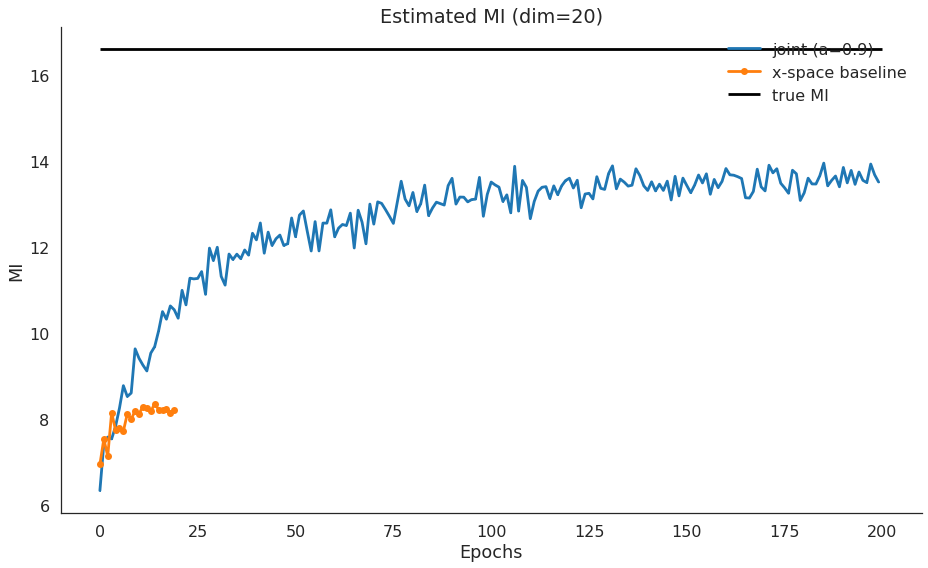

In [47]:
plt.figure(figsize=(13,8))

# plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=7)
# # plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
# plt.plot(range(len(disc)), joint[0:100], '-o', label='joint (a=0.1)', markersize=7)
# plt.plot(range(len(disc)), joint1[0:100], '-o', label='joint (a=0.5)', markersize=7)
# plt.plot(range(len(disc)), joint2[0:100], '-o', label='joint (a=0.9)', markersize=7)
# # plt.plot(range(len(disc)), baseline, '-o', label='x-space baseline', markersize=7)

# plt.plot(range(len(disc)), disc, '-o', label='disc', markersize=1)
# plt.plot(range(len(flow)), flow, '-o', label='flow', markersize=7)
# plt.plot(range(len(joint)), joint, '-o', label='joint (a=0.1)', markersize=1)
# plt.plot(range(len(joint)), joint1, '-o', label='joint (a=0.5)', markersize=1)
plt.plot(range(len(joint)), joint3, '-o', label='joint (a=0.9)', markersize=1)
plt.plot(range(len(baseline)), baseline, '-o', label='x-space baseline', markersize=7)

plt.hlines(16.61, 0, len(joint), color='black', label='true MI')

plt.xlabel('Epochs')
plt.ylabel('MI')
# plt.ylim(0, 2)
plt.title('Estimated MI (dim=20)')
plt.legend()
sns.despine()
plt.tight_layout()

In [38]:
def rho_to_mi(dim, rho):
    """Obtain the ground truth mutual information from rho."""
    return -0.5 * np.log(1 - rho**2) * dim


def mi_to_rho(dim, mi):
    """Obtain the rho for Gaussian give ground truth mutual information."""
    return np.sqrt(1 - np.exp(-2.0 / dim * mi))

In [39]:
rho_to_mi(20,0.9)

16.607312068216512